# 젠더 법안 K-means

In [18]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
%matplotlib inline

In [19]:
bill_df = pd.read_csv('./2021-bill-preprocessed.csv', 
                      index_col=0, parse_dates=['제안일자','의결일자','의결처리기간'] )
bill_df.drop('Unnamed: 13',1, inplace=True)
print(bill_df.shape)
bill_df.columns

(26140, 38)


Index(['의안번호', '의안명', '제안자구분', '제안일자', '의결일자', '의결결과', '제안회기', '제안이유', '소관위원회',
       '제안정당', '법률반영여부', '법률안', '개혁보수신당', '국민의당', '기본소득당', '대안신당', '대한애국당',
       '더불어민주당', '더불어시민당', '무소속', '미래를향한전진4.0', '미래통합당', '미래한국당', '민생당',
       '민주평화당', '민중당', '바른미래당', '바른정당', '새누리당', '새로운보수당', '새민중정당', '시대전환',
       '열린민주당', '우리공화당', '자유한국당', '정의당', '의결처리기간', '법률공포여부'],
      dtype='object')

In [47]:
# 의안번호 2014046 2018년 먼저 다크웹 규제 강화 법안 발의 but 임기만료폐기 
keyword = r'.*(N번방|n번방|불법촬영|스토킹|데이트폭력|데이트 폭력|디지털성범죄|사이버범죄|포르노|\
                카르텔|과다노출|사이버 범죄|몰래카메라|몰카|불법 촬영|몸캠|성폭력|성착취|성매매|성범죄|\
                버닝썬|성희롱|딥페이크|복제물|음란|성범죄|n번방|웹하드|촬영물|클럽|성접대|미투|그루밍|성희롱).*'
gender = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(1016, 38)

In [48]:
gender = gender[['의안번호','의안명','의결결과','제안이유']]
gender.head()

,의안번호,의안명,의결결과,제안이유
0,2024979,아동·청소년의 성보호에 관한 법률 일부개정법률안,원안가결,2 대안의 아동？청소년 음란물 범죄의 규모와 형태가 갈수록 교묘해지고 있지만 우...
1,2024963,정보통신망 이용촉진 및 정보보호 등에 관한 법률 일부개정법률안,원안가결,대안의 가 현행법상 금지되는 정보통신망 침해행위에 최근 정보통신망의 정상적인 보호...
2,2024959,전기통신사업법 일부개정법률안,원안가결,2 대안의 일부 기간통신사업자의 서비스별 요금 등에 관한 이용약관에 대하여 인가제...
3,2024926,아동·청소년의 성보호에 관한 법률 일부개정법률안,임기만료폐기,최근 N번방 사건으로 불리는 텔레그램을 통한 아동 청소년 성착취 사건으로 인해 사회...
4,2024925,특정강력범죄의 처벌에 관한 특례법 일부개정법률안,임기만료폐기,최근 N번방 사건으로 불리는 텔레그램을 통한 아동？청소년 성착취 사건으로 사회적 공...


In [49]:
# 한글 전처리
def preprocessing(text): 
    text = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return str(text)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
             '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등','안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [50]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(str)

In [51]:
%time contents = gender['의안텍스트'].apply(preprocessing)

CPU times: user 58.2 ms, sys: 3.52 ms, total: 61.7 ms
Wall time: 60.9 ms


In [52]:
okt = Okt()

def get_tokens(x):
    try:
        return [i for i in okt.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [53]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 27.1 s, sys: 233 ms, total: 27.3 s
Wall time: 26 s


0    [아동, 청소년, 보호, 법률, 일부, 개정, 법률, 대안, 아동, 청소년, 음란물...
1    [정보통신망, 이용, 촉진, 정보보호, 법률, 일부, 개정, 법률, 대안, 현행법,...
2    [전기통신사업법, 일부, 개정, 법률, 대안, 일부, 기간, 통신사, 업자, 서비스...
Name: tokens, dtype: object

In [54]:
# %time gender['tokens'] = gender['tokens'].apply(remove_stopword)

In [55]:
%time gender['명사수'] = gender['tokens'].apply(len)

CPU times: user 1.31 ms, sys: 113 µs, total: 1.42 ms
Wall time: 1.37 ms


In [56]:
# 명사 수가 50개를 넘어가는 경우만 추출
gender = gender[gender['명사수'] >= 50]
gender = gender.reset_index(drop=True)
print(gender_df.shape)

(991, 7)


In [32]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [33]:
# 모델 생성

#포스태깅된 컨텐츠를 100차원의 벡터로 바꿔라. 주변 단어(window)는 앞뒤로 두개까지 보고, 코퍼스 내 출현 빈도가 10번 미만인 단어는 분석에서 제외해라.
#CPU는 쿼드코어를 쓰고 100번 반복 학습해라. 분석방법론은 CBOW와 Skip-Gram 중 후자를 선택해라.
model = Word2Vec(gender['tokens'], size=300, window = 10, min_count=50, workers=4, iter=100, sg=1)

2020-08-31 22:30:58,218 : INFO : collecting all words and their counts
2020-08-31 22:30:58,219 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-31 22:30:58,246 : INFO : collected 5100 word types from a corpus of 117735 raw words and 1016 sentences
2020-08-31 22:30:58,248 : INFO : Loading a fresh vocabulary
2020-08-31 22:30:58,263 : INFO : effective_min_count=50 retains 486 unique words (9% of original 5100, drops 4614)
2020-08-31 22:30:58,265 : INFO : effective_min_count=50 leaves 83495 word corpus (70% of original 117735, drops 34240)
2020-08-31 22:30:58,274 : INFO : deleting the raw counts dictionary of 5100 items
2020-08-31 22:30:58,276 : INFO : sample=0.001 downsamples 87 most-common words
2020-08-31 22:30:58,278 : INFO : downsampling leaves estimated 62772 word corpus (75.2% of prior 83495)
2020-08-31 22:30:58,282 : INFO : estimated required memory for 486 words and 300 dimensions: 1409400 bytes
2020-08-31 22:30:58,289 : INFO : resetting layer wei

2020-08-31 22:31:03,150 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-31 22:31:03,153 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-31 22:31:03,155 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-31 22:31:03,156 : INFO : EPOCH - 15 : training on 117735 raw words (62716 effective words) took 0.3s, 187931 effective words/s
2020-08-31 22:31:03,456 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-31 22:31:03,473 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-31 22:31:03,478 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-31 22:31:03,480 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-31 22:31:03,481 : INFO : EPOCH - 16 : training on 117735 raw words (62955 effective words) took 0.3s, 196539 effective words/s
2020-08-31 22:31:03,804 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-08-31 22:31:08,147 : INFO : EPOCH - 31 : training on 117735 raw words (62862 effective words) took 0.3s, 188007 effective words/s
2020-08-31 22:31:08,484 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-31 22:31:08,499 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-31 22:31:08,504 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-31 22:31:08,510 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-31 22:31:08,511 : INFO : EPOCH - 32 : training on 117735 raw words (62762 effective words) took 0.4s, 175751 effective words/s
2020-08-31 22:31:08,844 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-31 22:31:08,856 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-31 22:31:08,869 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-31 22:31:08,877 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2020-08-31 22:31:13,851 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-31 22:31:13,856 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-31 22:31:13,864 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-31 22:31:13,864 : INFO : EPOCH - 48 : training on 117735 raw words (62776 effective words) took 0.3s, 201293 effective words/s
2020-08-31 22:31:14,147 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-31 22:31:14,160 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-31 22:31:14,169 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-31 22:31:14,171 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-31 22:31:14,172 : INFO : EPOCH - 49 : training on 117735 raw words (62656 effective words) took 0.3s, 208668 effective words/s
2020-08-31 22:31:14,457 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-08-31 22:31:18,983 : INFO : EPOCH - 64 : training on 117735 raw words (62808 effective words) took 0.3s, 200779 effective words/s
2020-08-31 22:31:19,294 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-31 22:31:19,298 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-31 22:31:19,306 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-31 22:31:19,328 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-31 22:31:19,329 : INFO : EPOCH - 65 : training on 117735 raw words (62790 effective words) took 0.3s, 185991 effective words/s
2020-08-31 22:31:19,621 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-31 22:31:19,652 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-31 22:31:19,657 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-31 22:31:19,663 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2020-08-31 22:31:25,053 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-31 22:31:25,062 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-31 22:31:25,069 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-31 22:31:25,070 : INFO : EPOCH - 81 : training on 117735 raw words (62917 effective words) took 0.3s, 188201 effective words/s
2020-08-31 22:31:25,444 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-31 22:31:25,449 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-31 22:31:25,453 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-31 22:31:25,459 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-31 22:31:25,460 : INFO : EPOCH - 82 : training on 117735 raw words (62762 effective words) took 0.4s, 163803 effective words/s
2020-08-31 22:31:25,776 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-08-31 22:31:30,808 : INFO : EPOCH - 97 : training on 117735 raw words (62848 effective words) took 0.3s, 179573 effective words/s
2020-08-31 22:31:31,100 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-31 22:31:31,125 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-31 22:31:31,128 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-31 22:31:31,132 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-31 22:31:31,133 : INFO : EPOCH - 98 : training on 117735 raw words (62851 effective words) took 0.3s, 197588 effective words/s
2020-08-31 22:31:31,450 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-31 22:31:31,451 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-31 22:31:31,463 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-31 22:31:31,465 : INFO : worker thread finished; awaiting finish of 0 more threads
20

In [58]:
# 문장 벡터 생성
def get_sentence_mean_vector(morphs):
    vector = []
    for i in morphs:
        try:
            vector.append(model.wv[i])
        except:
            pass
    try:
        return np.mean(vector, axis=0)
    except:
        pass
    
# 엘보우 함수
def elbow(X):
    sse = []
    for i in tqdm(range(1,15), desc = '엘보우'):
        km = KMeans(init='k-means++', n_clusters = i, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,15), sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.show()

In [59]:
# 문장 벡터 생성
gender['문장벡터'] = gender['tokens'].map(get_sentence_mean_vector)

In [60]:
len(gender['문장벡터'][0])

300

## 시각화

In [62]:
import time
from sklearn.manifold import TSNE

n_sne = 7000

wv_list = list(gender['문장벡터'])
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(wv_list)

tsne_df = pd.DataFrame(tsne_results, index=gender['의안명'], columns=["x", "y"])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 991 samples in 0.013s...
[t-SNE] Computed neighbors for 991 samples in 0.555s...
[t-SNE] Computed conditional probabilities for sample 991 / 991
[t-SNE] Mean sigma: 0.455873
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.131119
[t-SNE] KL divergence after 300 iterations: 0.949762


In [63]:
tsne_df.head()

,x,y
의안명,,
아동·청소년의 성보호에 관한 법률 일부개정법률안,-15.145157,-2.666269
정보통신망 이용촉진 및 정보보호 등에 관한 법률 일부개정법률안,-14.102983,6.616796
전기통신사업법 일부개정법률안,-6.684862,11.781427
아동·청소년의 성보호에 관한 법률 일부개정법률안,-15.133973,-2.427163
특정강력범죄의 처벌에 관한 특례법 일부개정법률안,-13.113525,-1.574042


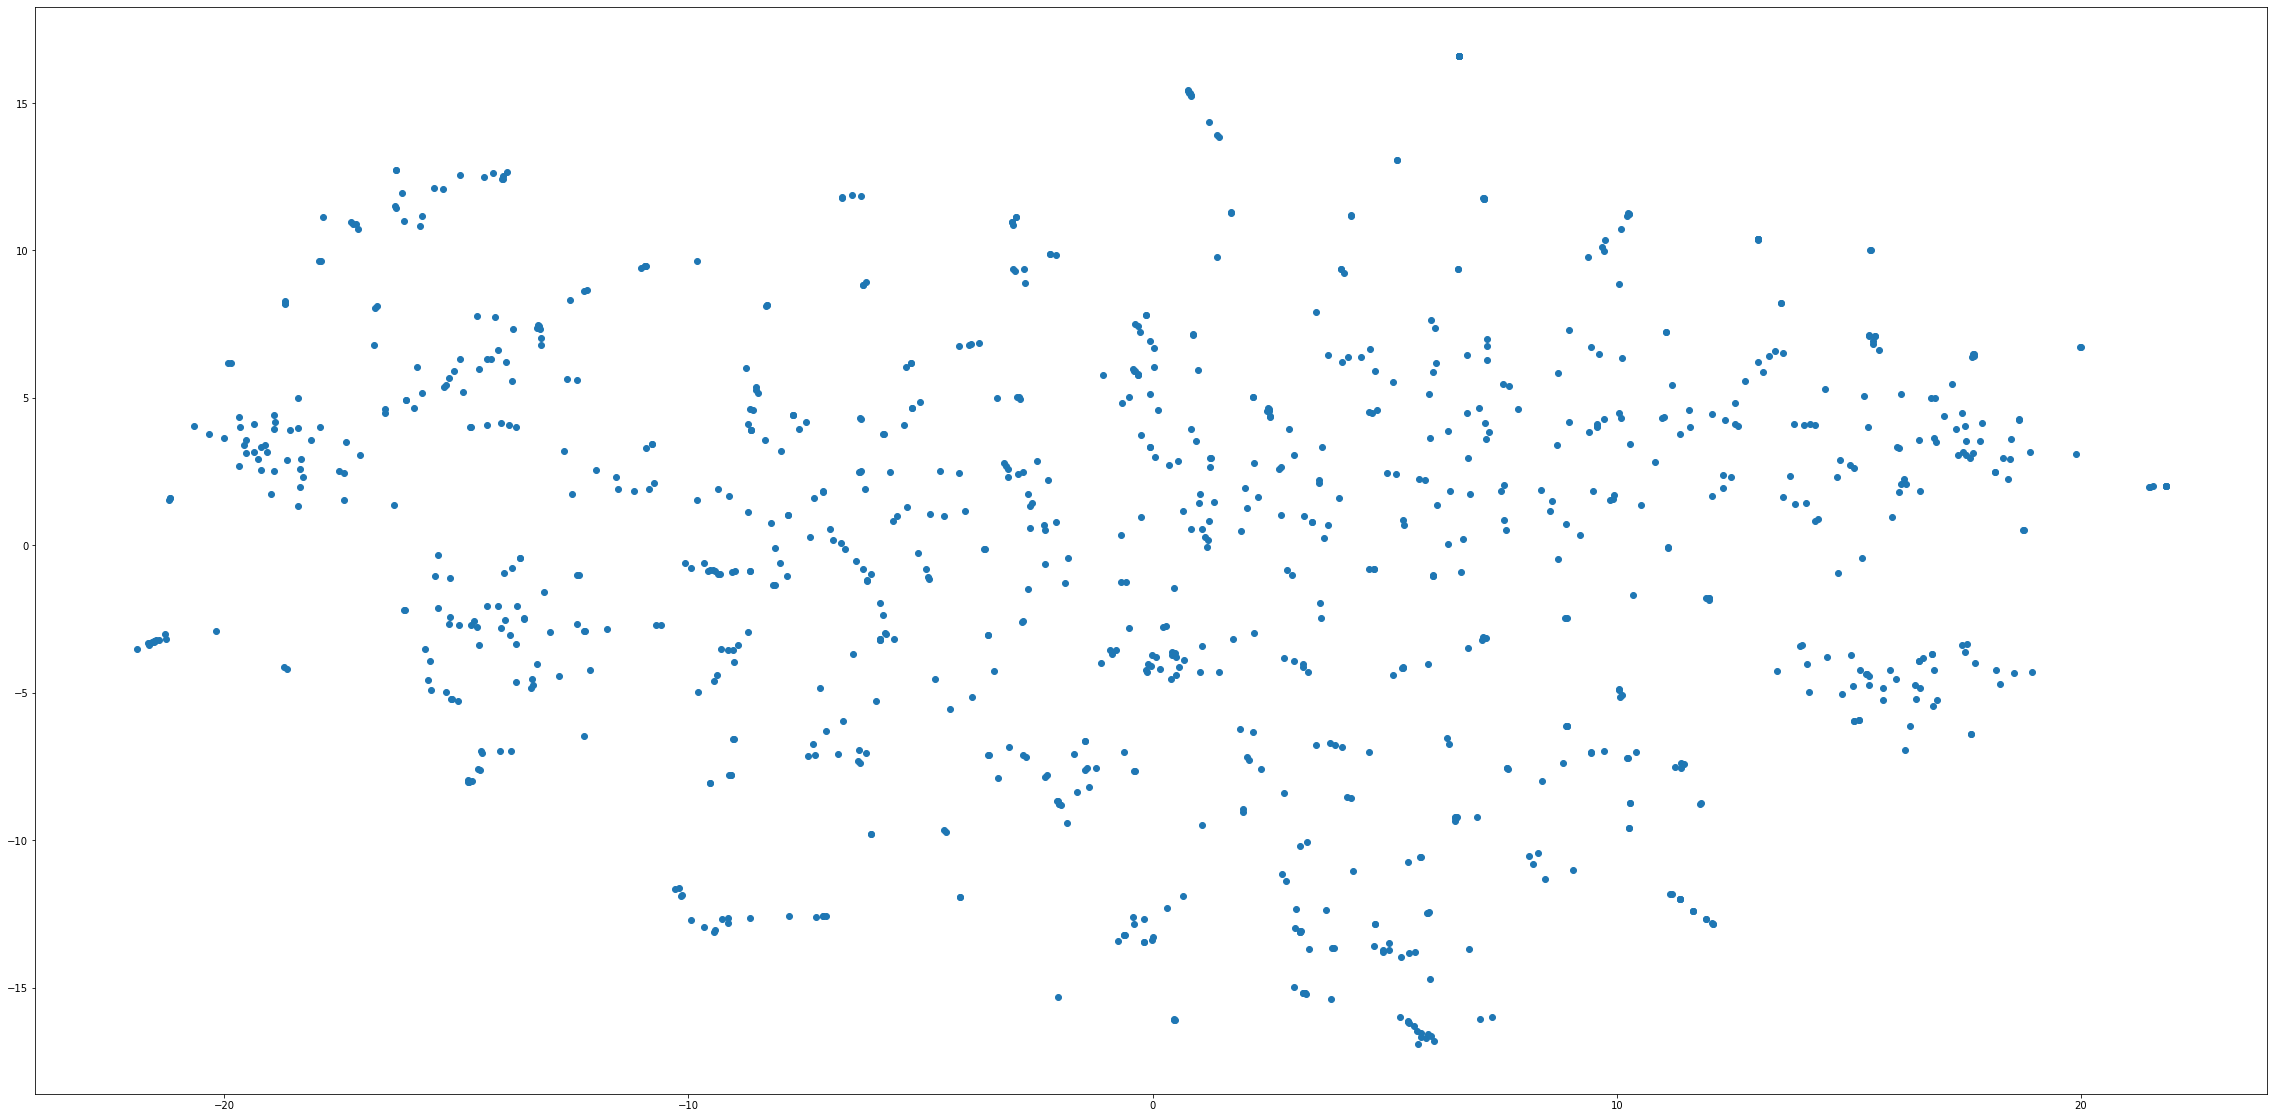

In [64]:
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_df["x"], tsne_df["y"])

#for word, pos in list(df.iterrows()):
#    ax.annotate(word, pos, fontsize=12, fontproperties=prop)
plt.show()

## 군집개수 결정 - 엘보우 함수

엘보우: 100%|██████████| 14/14 [00:02<00:00,  5.50it/s]


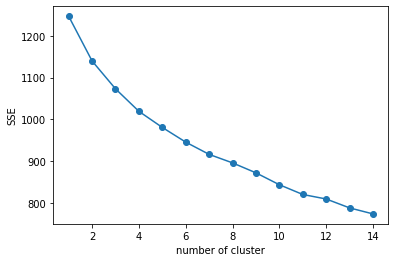

In [65]:
# 엘보우 함수로 군집 개수 결정

word_vectors = gender['문장벡터'].to_list() # 함수에 넣을 X값 지정
elbow(word_vectors)

## 군집개수 결정 - 실루엣 계수

In [66]:
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from matplotlib import cm

def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    plt.axvline(silhoutte_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('K')
    plt.xlabel('silhouette')
    plt.show()

## KMeans

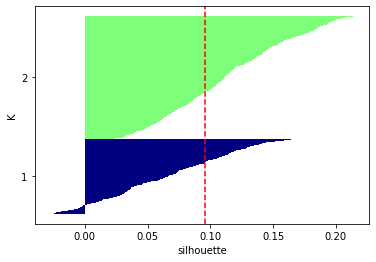

In [71]:
word_vectors = gender['문장벡터'].to_list()
k= 2

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

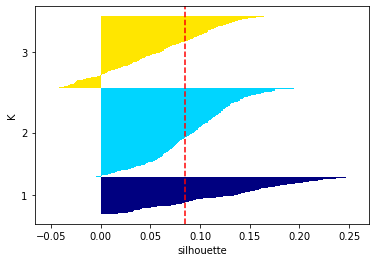

In [72]:
word_vectors = gender['문장벡터'].to_list()
k= 3

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

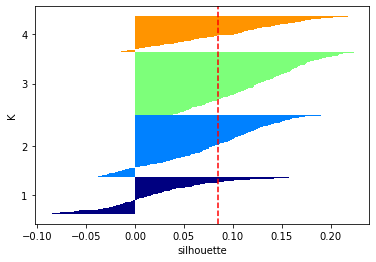

In [73]:
word_vectors = gender['문장벡터'].to_list()
k= 4

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

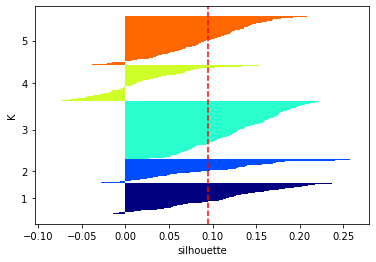

In [74]:
word_vectors = gender['문장벡터'].to_list()
k= 5

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

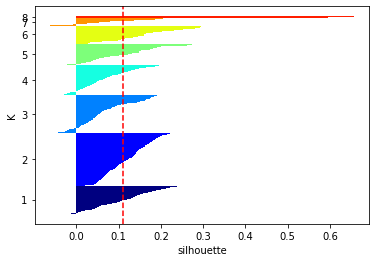

In [209]:
word_vectors = gender['문장벡터'].to_list()
k= 8

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

## KMeans 수행

In [201]:
# K means 수행 
word_vectors = gender['문장벡터'].to_list()
num_clusters = 7

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)
gender['category'] = idx

In [202]:
gender['category'].value_counts()

5    197
2    179
3    169
6    159
0    121
1     84
4     82
Name: category, dtype: int64

In [203]:
from sklearn.manifold import TSNE

X = gender['문장벡터'].to_list()
y = gender['category'].to_list()

import os.path
import pickle

tsne_filepath = 'tsne3000.pkl'

# File Cache
if not os.path.exists(tsne_filepath):
    tsne = TSNE(random_state=42)
    tsne_points = tsne.fit_transform(X)
    with open(tsne_filepath, 'wb+') as f:
        pickle.dump(tsne_points, f)
else: # Cache Hits!
    with open(tsne_filepath, 'rb') as f:
        tsne_points = pickle.load(f)

tsne_df = pd.DataFrame(tsne_points, index=range(len(X)), columns=['x_coord', 'y_coord'])
tsne_df['BillNo'] = gender['의안번호'].to_list()
tsne_df['BillName'] = gender['의안명'].to_list()
tsne_df['cluster_no'] = y

In [204]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.palettes import brewer

output_notebook()

Loading BokehJS ...

In [205]:
# 색 정해주기

colors = brewer["Spectral"][len(tsne_df['cluster_no'].unique())]
colormap = {i: colors[i] for i in tsne_df['cluster_no'].unique()}
colors = [colormap[x] for x in tsne_df['cluster_no']]
tsne_df['color'] = colors

In [206]:
# Bokeh가 인식하는 DataSource 객체 만들어주기
plot_data = ColumnDataSource(
    data=tsne_df.to_dict(orient='list')
)

# Plot 만들기(배경)
tsne_plot = figure(
    title='Bills about gender',
    plot_width = 650,
    plot_height = 650,
    active_scroll='wheel_zoom',
    output_backend="webgl", # GPU 가속
)

In [207]:
# 마우스 올렸을 때 보여줄 것

tsne_plot.add_tools(
    HoverTool(
        tooltips= '@BillName'
    )
)

# 데이터 정보 넣기

tsne_plot.circle(
    source=plot_data,
    x='x_coord',
    y='y_coord',
    line_alpha=0.3, 
    fill_alpha=0.2,
    size=10,
    fill_color='color',
    line_color='color',
)

# 선 지우기

tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None


show(tsne_plot)


- 짙은 초록은 남녀고용평등법(성희롱, 양성평등 관련 법안 등)
- 짙은 파란색은 공중화장실, 성매매 관련 법안
- 옅은 노란색은 아동 관련 법안 
- 맨위의 연두색은 형법 관련 법안
- 주황색은 각 분야 (의료, 지자체, 산림 , 농업) 등 임원들의 비위 (성폭력 포함) 관련 법안
- 빨간색은 데이트폭력, 스토킹, 가정폭력 관련 법안